# State and input discretization
A stage decision problem can be approximated by a discrete optimization problem 
by discretizing the state and the input, as depicted in Figure 1.


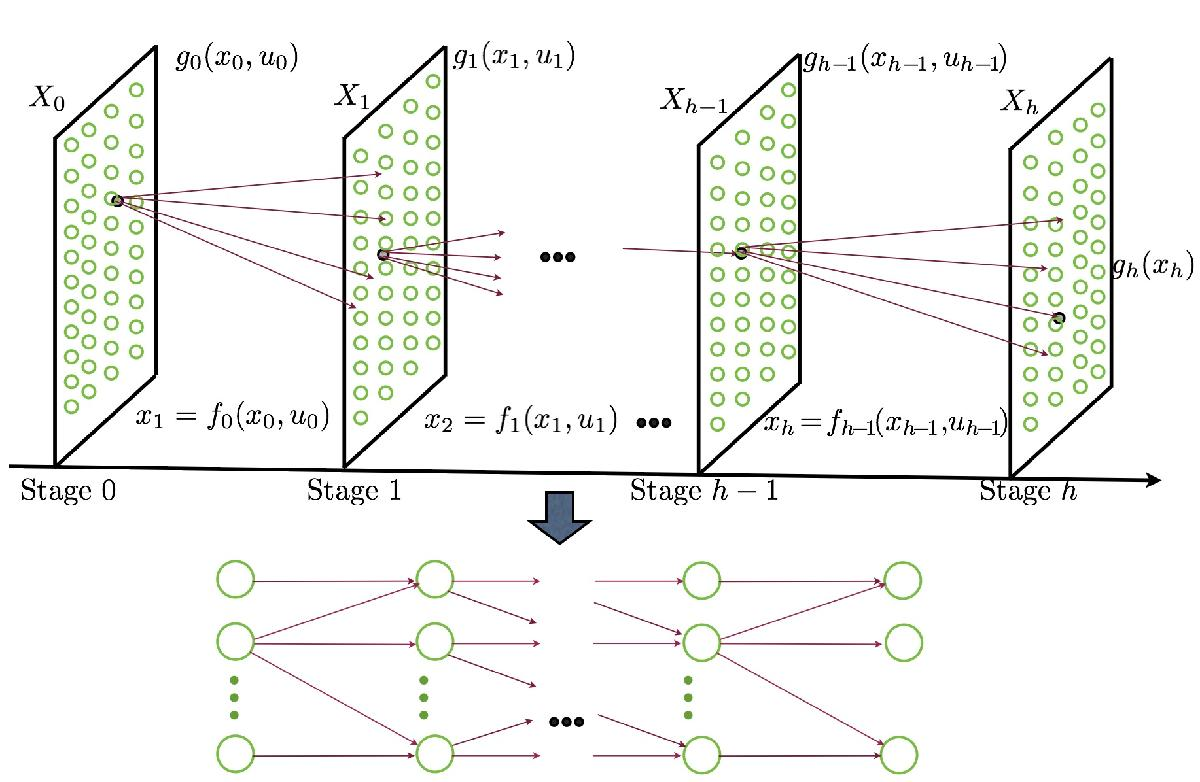
<center>Figure 1: State and input discretization</center>

In this example, we illustrate this fact and use it to move the position of 
a double integrator system from zero initial condtions to an unitary position 
and zero velocity with mininum quadratic input cost. Formally,

$$\min \int_0^1u^2 dt$$

$$\dot{z} = v$$

$$\dot{v}=u$$

$$z(0)=0, \ \ v(0)=0, \ \ z(1)=0, \ \ v(1)=0. $$

The optimal solution to this problem can be obtained by the Pontryagin's maximum 
principle and is given by

$$z=3t^2-2t^3,  v=6t-6t^2,  u=6-12t$$

The model of a double integration after temporal discretization with a zero 
order hold input is

$$ x_{k+1}=Ax_k+Bu_k$$

where $k\in\{0,\dots,h-1\}$, $x_k$ comprises position $z_k$ and velocity 
$v_k$, i.e., $x_k= [z_k \ \ v_k]^T$, and the control input is $u_k$, and

$$A=e^{\left[ \matrix{ 0     & \tau \cr    0& 0 } \right]}={\left[ \matrix{ 
1    & \tau \cr    0& 1 } \right]} B = \int_0^\tau e^{As}ds\left[\matrix{0 
\cr 1} \right] = \left[\matrix{\frac{\tau^2}{2} \cr \tau} \right].$$

We quantize/discretize the state and input variables as follows

$$v_k \in \delta_v \bar{v}_k$$

$$z_k \in \delta_z\bar{z}_k$$

$$u_k=\delta_u\hat{u}_k$$

where $\hat{u}_k = \bar{u}_k-1-(n_u-1)/2$ and

$$\bar{u}_k \in \{1,2,\dots,n_u\}$$

$$\bar{v}_k \in \{0,1,\dots,n_v\}$$

$$\bar{z}_k \in \{0,1,\dots,n_z\}$$

Moreover, we define

$$\bar{x}_k=1+\bar{v}_k+(n_v+1)\bar{z}_k$$

from which we conclude that 

$$\bar{x}_k \in \{1,2,\dots,n_x\}$$

with $n_x = (n_z+1)(n_v+1)$. If we choose $\delta_z=\delta_u\tau^2/2$, $\delta_v=\delta_u\tau$, 
we can conclude that 

$$\bar{z}_{k+1}=\bar{z}_k+2\bar{v}_k+\hat{u}_k$$

$$\bar{v}_{k+1}=\bar{v}_k+\hat{u}_k$$

from which we can obtain a relation

$$\bar{x}_{k+1}=f(\bar{x}_k,\bar{u_k})$$

for the cost function we can simply write

$$\tau\sum_{k=0}^{K-1}u_k^2 \rightarrow \tau\delta_u^2\sum_{k=0}^{K-1}\hat{u}_k^2 
$$

The terminal and initial condtions are 

$$J_h(\bar{x}_h) = 0  \text{ if } \bar{x}_h = 1+0+(n_v+1)(n_z)$$

$$J_h(\bar{x}_h)=\infty \text{ otherwise, and } \bar{x}_0=1+0+(n_v+1)(0)=1.$$

The following script allows to access how close the response is to the optimal 
continuous-time solution given above.


In [ ]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
%matplotlib ipympl

In [ ]:
def dp(M, C, Jh, h):
 
    n = M.shape[0]
    J = Jh
    
    J_ = np.zeros((n,h))
    u_ = np.zeros((n,h))
    ind = np.arange(M.shape[1]).reshape(M.shape[1],1)
    
    for k in range(h-1,-1,-1):
        for i in range(n):
            aux = [int(M[i,:][idx]) for idx in range(71)]
            J_[i,k] = np.min( C[[i],:].T + J[aux])
            c = ind[J_[i,k] == (C[[i],:].T + J[aux])]
            u_[i,k] = c[-1]+1
    
        J = J_[:,[k]]
    
    return  u_,J_

In [ ]:
#parameters 
dt = 0.5
K = int(np.round(1/dt))
du = 0.2
dv = dt*du
dd = dt**2/2*du
 
nu = int(2*(7/du)+1)
nv = int(np.round(2/dv))
nd = int(np.round(1/dd))
nx = (nd+1)*(nv+1)

#formulation
D   = np.floor((np.arange(nx).reshape(1,nx))/(nv+1)).T @ np.ones((1,int(nu)))
V   = np.mod(np.arange(nx).reshape(nx,1),nv+1)@np.ones((1,nu))
aux = np.floor((nu-1)/2)
U   = np.ones((nx,1))*np.arange(-aux,aux+1).reshape(1,nu)
V_1 = np.minimum(np.maximum(V+U,np.zeros((nx,nu))),np.ones((nx,nu))*nv)
D_1 = np.minimum(np.maximum(D + 2*V + U,np.zeros((nx,nu))),np.ones((nx,nu))*nd)
X_1 = V_1 + (nv+1)*D_1 #+1

M  = X_1
C  = np.ones((nx,1))@(np.arange(-aux,aux+1)**2).reshape(1,nu)
Jh = np.inf*np.ones((nx,1))
Jh[nd*(nv+1)] = 1

#Get policy with DP and run system
mu, J = dp( M, C, Jh, K)

 
#obtain u and x for the given initial position from the policy obtain (get
#optimal path)
d      = np.zeros((1,K+1))
v      = np.zeros((1,K+1))
xbar   = np.zeros((1,K+1))
u      = np.zeros((1,K))
ubar   = np.zeros((1,K))
xbar[0]   = 1
d[0] = 0
v[0] = 0
for k in range(K):
    ubar[:,k]    = mu[int(xbar[:,k]),k]
    xbar[:,k+1]   = M[int(xbar[:,k]),int(ubar[:,k])]
    u[:,k]        = (ubar[:,k]-(nu-1)/2-1)*du
    d[:,k+1]       = np.floor( (xbar[:,k+1]-1)/(nv+1) )*dd
    v[:,k+1]       = np.mod( (xbar[:,k+1]-1),nv+1 )*dv

# cost
cost = dt*J[0,0]*du**2

In [ ]:
cost

In [ ]:
# Plots
hsol = 0.0001
tsol = np.arange(0,1,hsol)
zsol = 3*tsol**2-2*tsol**3
vsol = 6*tsol - 6*tsol**2
usol = 6-12*tsol

f, ax = plt.subplots(1,3)
kvec = np.arange(K+1)/K
ax[0].stem(kvec[:-1], u[0])
ax[0].plot(tsol, usol, 'g')
ax[0].set_xlabel('time')
ax[0].legend(['$u_k$', '$u(t)$'])
ax[0].grid(True)

ax[1].stem(kvec,d[0])
ax[1].plot(tsol,zsol,'g')
ax[1].set_xlabel('time')
ax[1].legend(['$x_k$', '$x(t)$'])
ax[1].grid(True)

ax[2].stem(kvec,v[0])
ax[2].plot(tsol,vsol,'g')
ax[2].set_xlabel('time')
ax[2].legend(['$v_k$', '$v(t)$'])
ax[2].grid(True)